In [1]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.expressions import Beta, DefineVariable, Derive, log, bioDraws, MonteCarlo
import math
import random
import biogeme.results as res
from random import randint
import os, inspect
from sklearn.utils import shuffle
import numpy as np


import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/CFS')

In [2]:
region_df = pd.read_csv('CFS2017_national_forML_short.csv')
factor_df = pd.read_csv('data_unitcost_by_zone_cfs2017.csv')
sctg_group = pd.read_csv('SCTG_Groups_revised.csv')
cfs_to_faf_lookup = pd.read_csv('CFS_FAF_LOOKUP.csv')
print(region_df.columns)
region_df.head(5)

Index(['SHIPMT_ID', 'ORIG_STATE', 'ORIG_MA', 'ORIG_CFS_AREA', 'DEST_STATE',
       'DEST_MA', 'DEST_CFS_AREA', 'NAICS', 'QUARTER', 'SCTG', 'MODE',
       'SHIPMT_VALUE', 'SHIPMT_WGHT', 'SHIPMT_DIST_GC', 'SHIPMT_DIST_ROUTED',
       'TEMP_CNTL_YN', 'EXPORT_YN', 'EXPORT_CNTRY', 'HAZMAT', 'WGT_FACTOR',
       'mode_agg5', 'bulk', 'fuel_fert', 'interm_food', 'mfr_goods', 'other',
       'commodity', 'naics2', 'naics_name', 'wholesale', 'mfring', 'mining',
       'retail', 'info', 'management', 'transwarehouse', 'SHIPMT_WGHT_TON',
       'value_density', 'SHIPMT_DIST', 'choice', 'travel_time', 'ship_cost'],
      dtype='object')


,SHIPMT_ID,ORIG_STATE,ORIG_MA,ORIG_CFS_AREA,DEST_STATE,DEST_MA,DEST_CFS_AREA,NAICS,QUARTER,SCTG,...,retail,info,management,transwarehouse,SHIPMT_WGHT_TON,value_density,SHIPMT_DIST,choice,travel_time,ship_cost
0,1,6,99999,06-99999,6,260,06-260,326,4,43,...,0,0,0,0,0.1955,11.202046,60,4,16.923077,5.278500
1,2,49,482,49-482,47,314,47-314,4541,3,43,...,1,0,0,0,0.0020,14.000000,1524,3,72.000000,68.169687
2,3,6,348,06-348,6,348,06-348,4231,4,34,...,0,0,0,0,0.2200,0.579545,5,4,16.076923,0.220000
3,4,6,260,06-260,6,99999,06-99999,212,4,11,...,0,0,0,0,22.4560,0.005566,35,4,16.538462,121.262400
4,5,45,273,45-273,45,273,45-273,45431,4,19,...,1,0,0,0,0.0365,0.630137,11,4,16.169231,0.929655


In [3]:
region_df.loc[:, ['SHIPMT_VALUE', 'SHIPMT_WGHT', 'value_density']].head(10)

,SHIPMT_VALUE,SHIPMT_WGHT,value_density
0,4380,391,11.202046
1,56,4,14.000000
2,255,440,0.579545
3,250,44912,0.005566
4,46,73,0.630137
5,605,4,151.250000
6,9391,36974,0.253989
7,1594,665,2.396992
8,1918,38,50.473684
9,1969,18,109.388889


In [4]:
# clean the data

df_clean = region_df.loc[region_df.EXPORT_YN == 'N'] # Cleans out international exports

def removeOutliers(sName, df):
    # Computing IQR
    Q1 = df[sName].quantile(0.25)
    Q3 = df[sName].quantile(0.75)
    IQR = Q3 - Q1

    # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
    filtered = df.query(sName + '<= (@Q3 + 3 * @IQR)')
    
    return filtered

df_clean = removeOutliers('SHIPMT_WGHT', df_clean)
df_clean = removeOutliers('SHIPMT_DIST', df_clean)
print(len(df_clean))

4683648


In [5]:
sctg_group.head(5)
df_clean = pd.merge(df_clean, sctg_group,
                    left_on = 'SCTG',
                    right_on = 'SCTG_Code',
                    how = 'left')

In [6]:
var_to_keep = ['SHIPMT_ID', 'ORIG_CFS_AREA', 'DEST_CFS_AREA', 'NAICS', 'naics_name',
               'SCTG', 'SCTG_Group', 'SHIPMT_VALUE', 'SHIPMT_WGHT', 'SHIPMT_DIST', 'value_density']

df_clean_choice_model = df_clean[var_to_keep]
dist_matrix = df_clean_choice_model.groupby(['ORIG_CFS_AREA', 'DEST_CFS_AREA'])[['SHIPMT_DIST']].mean()
dist_matrix.columns = ['Distance']
dist_matrix = dist_matrix.reset_index()

cfs_to_faf_short = cfs_to_faf_lookup[['ST_MA',	'FAF']]
dist_matrix = pd.merge(dist_matrix, cfs_to_faf_short, 
                       left_on = 'ORIG_CFS_AREA', right_on = 'ST_MA', how = 'left')
dist_matrix = dist_matrix.rename(columns = {'FAF': 'orig_FAFID'})
dist_matrix = pd.merge(dist_matrix, cfs_to_faf_short, 
                       left_on = 'DEST_CFS_AREA', right_on = 'ST_MA', how = 'left')
dist_matrix = dist_matrix.rename(columns = {'FAF': 'dest_FAFID'})
dist_matrix = dist_matrix[['ORIG_CFS_AREA', 'DEST_CFS_AREA', 'orig_FAFID', 'dest_FAFID', 'Distance']]
dist_matrix.to_csv('CFS2017_routed_distance_matrix.csv')
print(dist_matrix.head(5))

df_clean_choice_model = df_clean_choice_model.sample(frac=0.05, replace=False, random_state=1)

  ORIG_CFS_AREA DEST_CFS_AREA  orig_FAFID  dest_FAFID     Distance
0        01-142        01-142          11          11    20.751917
1        01-142        01-380          11          12   241.504532
2        01-142      01-99999          11          19    85.552541
3        01-142      04-38060          11          41  1552.188235
4        01-142        04-536          11          42  1409.022727


<AxesSubplot:>

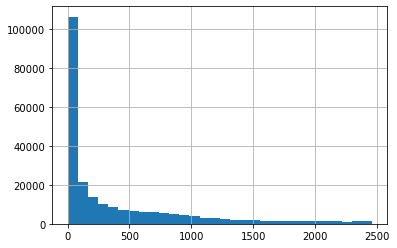

In [10]:
df_clean_choice_model.SHIPMT_DIST.hist(bins = 30)

In [11]:
unique_naics = df_clean_choice_model.NAICS.unique()
df_clean_choice_model.loc[:, 'chosen'] = 0
supplier_selection_set = None
for naics in unique_naics:
    print(naics)
    all_suppliers = \
    df_clean_choice_model.loc[df_clean_choice_model['NAICS'] == naics]   
    chunk_of_suppliers = np.array_split(all_suppliers, 10)
    #print(chunk_of_suppliers[0].head(5))
    for i in range(10):
        chunk = chunk_of_suppliers[i]
        chunk.loc[:, 'chosen'] = 1
        #print(chunk.columns)
        shipment_to_match = chunk[['SHIPMT_ID', 'DEST_CFS_AREA', 
                                   'NAICS', 'naics_name', 'SCTG', 'SCTG_Group', 'SHIPMT_WGHT']]
        selected_shipment = chunk.SHIPMT_ID.unique()
        non_chosen_set = \
        all_suppliers.loc[~all_suppliers['SHIPMT_ID'].isin(selected_shipment)]
        non_chosen_set = non_chosen_set[['ORIG_CFS_AREA', 'NAICS', 
                                         'naics_name', 'SCTG', 'value_density', 'chosen']]
        non_chosen_set = pd.merge(shipment_to_match, non_chosen_set,
                                  on = ['NAICS', 'naics_name', 'SCTG'], how = 'left')
        non_chosen_set = pd.merge(non_chosen_set, dist_matrix, 
                                  on = ['ORIG_CFS_AREA', 'DEST_CFS_AREA'], how = 'left')
        non_chosen_set.loc[:, 'SHIPMT_DIST'].fillna(5000, inplace = True)
        non_chosen_set.loc[:, 'value_density'] = \
        non_chosen_set.loc[:,'value_density'].fillna(non_chosen_set.groupby('SCTG')['value_density'].transform('mean'))
        non_chosen_set.loc[:, 'SHIPMT_VALUE'] = \
        non_chosen_set.loc[:, 'SHIPMT_WGHT'] * non_chosen_set.loc[:, 'value_density']
        non_chosen_set = non_chosen_set.groupby('SHIPMT_ID').sample(n=9, replace = True, random_state=1)
        #print(non_chosen_set.head(5))
        combined_set = pd.concat([chunk, non_chosen_set])
        combined_set = combined_set.sort_values('SHIPMT_ID')
#         print(combined_set.head(20))
        supplier_selection_set = pd.concat([supplier_selection_set, combined_set])
#         break
        
#     break

4248
4241
314
325
4235
322
332
4541
4244
4237
326
4246
4233
4238
333
334
4231
212
339
331
312
323
315
4931
4247
5111
4236
4234
4249
551114
4239
4242
313
4232
45431
311
316
337
321
336
327
335
4243
4245
324


In [12]:
# creat label
supplier_selection_set.loc[:, 'SHIPMT_VALUE'] = \
supplier_selection_set.loc[:, 'SHIPMT_VALUE'].fillna(supplier_selection_set.groupby('SHIPMT_ID')['SHIPMT_VALUE'].transform('mean'))
supplier_selection_set = shuffle(supplier_selection_set)
print(len(supplier_selection_set))
supplier_selection_set = supplier_selection_set.sort_values('SHIPMT_ID')
supplier_selection_set['alternative'] = \
supplier_selection_set.groupby('SHIPMT_ID').cumcount() + 1
supplier_selection_set['choice'] = 0
supplier_selection_set.loc[supplier_selection_set['chosen'] == 1, 'choice'] = \
supplier_selection_set.loc[supplier_selection_set['chosen'] == 1, 'alternative']

supplier_selection_set.head(10)

2341820


,SHIPMT_ID,ORIG_CFS_AREA,DEST_CFS_AREA,NAICS,naics_name,SCTG,SCTG_Group,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST,value_density,chosen,alternative,choice
263868,12,29-312,32-332,4234,Wholesale,38,4,69.700000,34,1183.514706,2.050000,0.0,1,0
264699,12,09-99999,32-332,4234,Wholesale,38,4,83980.000000,34,2321.857143,2470.000000,0.0,2,0
264835,12,19-99999,32-332,4234,Wholesale,38,4,2896.634146,34,1328.396396,85.195122,0.0,3,0
263974,12,13-122,32-332,4234,Wholesale,38,4,12920.000000,34,1814.378571,380.000000,0.0,4,0
264586,12,53-500,32-332,4234,Wholesale,38,4,340.000000,34,984.682540,10.000000,0.0,5,0
263883,12,42-428,32-332,4234,Wholesale,38,4,1904.000000,34,2193.148936,56.000000,0.0,6,0
264644,12,25-148,32-332,4234,Wholesale,38,4,2567.000000,34,2366.890625,75.500000,0.0,7,0
264800,12,41-440,32-332,4234,Wholesale,38,4,34.000000,34,892.100671,1.000000,0.0,8,0
9,12,06-348,32-332,4234,Wholesale,38,4,1049.000000,34,227.000000,30.852941,1.0,9,9
264454,12,29-476,32-332,4234,Wholesale,38,4,1768.000000,34,1434.559140,52.000000,0.0,10,0


In [13]:
# append capacity
factor_df.head(5)
supplier_selection_set = pd.merge(supplier_selection_set, factor_df,
                                 left_on = ['ORIG_CFS_AREA', 'SCTG'],
                                 right_on = ['ORIG_CFS_AREA', 'Commodity_SCTG'],
                                 how = 'left')
supplier_selection_set.loc[:, 'Capacity'] = \
supplier_selection_set.loc[:, 'Capacity'].fillna(supplier_selection_set.groupby('SHIPMT_ID')['Capacity'].transform('mean'))
supplier_selection_set.head(5)

,SHIPMT_ID,ORIG_CFS_AREA,DEST_CFS_AREA,NAICS,naics_name,SCTG,SCTG_Group,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST,value_density,chosen,alternative,choice,Commodity_SCTG,Capacity,UnitCost
0,12,29-312,32-332,4234,Wholesale,38,4,69.700000,34,1183.514706,2.050000,0.0,1,0,38.0,16579.86675,80989.250375
1,12,09-99999,32-332,4234,Wholesale,38,4,83980.000000,34,2321.857143,2470.000000,0.0,2,0,38.0,1081.81500,90862.617823
2,12,19-99999,32-332,4234,Wholesale,38,4,2896.634146,34,1328.396396,85.195122,0.0,3,0,38.0,77517.95860,48489.887410
3,12,13-122,32-332,4234,Wholesale,38,4,12920.000000,34,1814.378571,380.000000,0.0,4,0,38.0,113045.01115,86183.574922
4,12,53-500,32-332,4234,Wholesale,38,4,340.000000,34,984.682540,10.000000,0.0,5,0,38.0,281526.17820,31470.364712


In [15]:
# convert long data to wide
choice = supplier_selection_set.loc[supplier_selection_set['chosen'] == 1, 
                                     ['SHIPMT_ID',	'NAICS', 'SCTG_Group', 'choice']]

factor_1 = pd.pivot_table(supplier_selection_set, values='SHIPMT_VALUE', index=['SHIPMT_ID'],
                    columns=['alternative'], aggfunc=np.mean)
factor_1.columns = ['value_' + str(i+1) for i in range(10)]
factor_1 = factor_1.reset_index()
# factor_1.head(5)

factor_2 = pd.pivot_table(supplier_selection_set, values='SHIPMT_DIST', index=['SHIPMT_ID'],
                    columns=['alternative'], aggfunc=np.mean)
factor_2.columns = ['distance_' + str(i+1) for i in range(10)]
# factor_2 = factor_2.fillna(1)
factor_2 = factor_2.reset_index()

factor_3 = pd.pivot_table(supplier_selection_set, values='Capacity', index=['SHIPMT_ID'],
                    columns=['alternative'], aggfunc=np.mean)
factor_3.columns = ['capacity_' + str(i+1) for i in range(10)]
# factor_2 = factor_2.fillna(1)
factor_3 = factor_3.reset_index()
# factor_2.head(5)

destination_choice_data_wide = pd.merge(choice, factor_1, 
                                        on = 'SHIPMT_ID', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_2, 
                                        on = 'SHIPMT_ID', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_3, 
                                        on = 'SHIPMT_ID', how = 'left')
destination_choice_data_wide.head(5)

,SHIPMT_ID,NAICS,SCTG_Group,choice,value_1,value_2,value_3,value_4,value_5,value_6,...,capacity_1,capacity_2,capacity_3,capacity_4,capacity_5,capacity_6,capacity_7,capacity_8,capacity_9,capacity_10
0,12,4234,4,9,69.700000,83980.000000,2896.634146,12920.000000,340.000000,1904.000000,...,1.657987e+04,1.081815e+03,7.751796e+04,1.130450e+05,2.815262e+05,3.496760e+04,9.824738e+04,6.206106e+04,2.920445e+05,5.797725e+04
1,37,322,4,9,166.419162,137.635575,311.035242,71.363797,338.432161,433.295630,...,1.737632e+06,7.118303e+05,1.943005e+06,1.126324e+06,1.604436e+06,7.484675e+05,1.130678e+06,3.592784e+05,6.221749e+05,4.221613e+06
2,51,4243,2,1,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,...,3.630039e+06,3.630039e+06,3.630039e+06,3.630039e+06,3.630039e+06,3.630039e+06,3.630039e+06,3.630039e+06,3.630039e+06,3.630039e+06
3,75,4232,4,1,2009.000000,10066.536842,20864.000000,3632.150888,5607.200000,35599.200000,...,8.587883e+05,3.423734e+04,1.245342e+04,2.038909e+06,1.360578e+06,4.704864e+04,2.038909e+06,1.400643e+05,1.659899e+05,2.769820e+05
4,103,4541,4,10,17.000000,14.000000,772.000000,53.000000,19.000000,15.666667,...,8.267298e+05,3.724457e+06,1.360578e+06,2.494880e+06,4.174772e+04,6.291174e+05,1.779137e+05,2.285810e+05,8.264547e+04,3.663298e+06


In [16]:
# add availability
destination_choice_data_wide.loc[:, 'av_1'] = 1
destination_choice_data_wide.loc[:, 'av_2'] = 1
destination_choice_data_wide.loc[:, 'av_3'] = 1
destination_choice_data_wide.loc[:, 'av_4'] = 1
destination_choice_data_wide.loc[:, 'av_5'] = 1
destination_choice_data_wide.loc[:, 'av_6'] = 1
destination_choice_data_wide.loc[:, 'av_7'] = 1
destination_choice_data_wide.loc[:, 'av_8'] = 1
destination_choice_data_wide.loc[:, 'av_9'] = 1
destination_choice_data_wide.loc[:, 'av_10'] = 1

In [20]:
sctg_groups = destination_choice_data_wide.SCTG_Group.unique()
for sctg in sctg_groups:
    print(sctg)
    destination_choice_data_selected = \
    destination_choice_data_wide.loc[destination_choice_data_wide['SCTG_Group'] == sctg]
    database = db.Database('destination_choice', destination_choice_data_selected)
    globals().update(database.variables)
    database.fullData
    # define parameters
    B_VALUE = Beta('B_VALUE', 0, None, None, 0)
    B_DISTANCE_LOW = Beta('B_DISTANCE_LOW', 0, None, None, 0)
    B_DISTANCE_HIGH = Beta('B_DISTANCE_HIGH', 0, None, None, 0)
    B_DISTANCE_CONST = Beta('B_DISTANCE_CONST', 0, None, None, 0)
#     B_CAPACITY = Beta('B_CAPACITY', 0, None, None, 0)

    # B_VALUE_S = Beta('B_VALUE_S', 0.0001, None, None, 0)
    # B_DISTANCE_S = Beta('B_DISTANCE_S', 0.01, None, None, 0)
    # Define a random parameter with a normal distribution, designed to be used
    # for quasi Monte-Carlo simulation with Halton draws (base 5).
    # B_VALUE_RND = B_VALUE + B_VALUE_S * bioDraws('B_TIME_RND', 'NORMAL_HALTON5')
    # B_DISTANCE_RND = B_DISTANCE + B_DISTANCE_S * bioDraws('B_DISTANCE_RND', 'NORMAL_HALTON5')


    V1 = B_VALUE * value_1 + B_DISTANCE_LOW * distance_1 * (distance_1 <= 500) + \
    B_DISTANCE_HIGH * distance_1 * (distance_1 > 500) + \
    B_DISTANCE_CONST * (distance_1 > 500)
    
    V2 = B_VALUE * value_2 + B_DISTANCE_LOW * distance_2 * (distance_2 <= 500) + \
    B_DISTANCE_HIGH * distance_2 * (distance_2 > 500) + \
    B_DISTANCE_CONST * (distance_2 > 500)
    
    V3 = B_VALUE * value_3 + B_DISTANCE_LOW * distance_3 * (distance_3 <= 500) + \
    B_DISTANCE_HIGH * distance_3 * (distance_3 > 500) + \
    B_DISTANCE_CONST * (distance_3 > 500)
    
    V4 = B_VALUE * value_4 + B_DISTANCE_LOW * distance_4 * (distance_4 <= 500) + \
    B_DISTANCE_HIGH * distance_4 * (distance_4 > 500) + \
    B_DISTANCE_CONST * (distance_4 > 500)
    
    V5 = B_VALUE * value_5 + B_DISTANCE_LOW * distance_5 * (distance_5 <= 500) + \
    B_DISTANCE_HIGH * distance_5 * (distance_5 > 500) + \
    B_DISTANCE_CONST * (distance_5 > 500)
    
    V6 = B_VALUE * value_6 + B_DISTANCE_LOW * distance_6 * (distance_6 <= 500) + \
    B_DISTANCE_HIGH * distance_6 * (distance_6 > 500) + \
    B_DISTANCE_CONST * (distance_6 > 500)
    
    V7 = B_VALUE * value_7 + B_DISTANCE_LOW * distance_7 * (distance_7 <= 500) + \
    B_DISTANCE_HIGH * distance_7 * (distance_7 > 500) + \
    B_DISTANCE_CONST * (distance_7 > 500)
    
    V8 = B_VALUE * value_8 + B_DISTANCE_LOW * distance_8 * (distance_8 <= 500) + \
    B_DISTANCE_HIGH * distance_8 * (distance_8 > 500) + \
    B_DISTANCE_CONST * (distance_8 > 500)
    
    V9 = B_VALUE * value_9 + B_DISTANCE_LOW * distance_9 * (distance_9 <= 500) + \
    B_DISTANCE_HIGH * distance_9 * (distance_9 > 500) + \
    B_DISTANCE_CONST * (distance_9 > 500)
    
    V10 = B_VALUE * value_10 + B_DISTANCE_LOW * distance_10 * (distance_10 <= 500) + \
    B_DISTANCE_HIGH * distance_10 * (distance_10 > 500) + \
    B_DISTANCE_CONST * (distance_10 > 500)

    V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
        6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

    av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
          6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}
    # logprob = models.loglogit(V, None, choice)
    logprob = models.loglogit(V, av, choice)
    biogeme = bio.BIOGEME(database, logprob)
    biogeme.modelName = 'supplier_selection_national'
    biogeme.calculateNullLoglikelihood(av)
    # Estimate the parameters
    results = biogeme.estimate()

    # Get the results in a pandas table
    pandasResults = results.getEstimatedParameters()
    goodness_of_fit = results.getGeneralStatistics()
    print('estimation results')
    print(pandasResults)
    print(goodness_of_fit['Rho-square for the null model'][0])

4
estimation results
                     Value       Std err      t-test  p-value  Rob. Std err  \
B_DISTANCE_CONST -2.924831  1.358787e-02 -215.253122      0.0  1.331703e-02   
B_DISTANCE_HIGH  -0.000563  8.690907e-06  -64.817036      0.0  8.653520e-06   
B_DISTANCE_LOW   -0.007976  3.499858e-05 -227.883760      0.0  3.788815e-05   
B_VALUE          -0.000008  1.507396e-07  -49.866078      0.0  7.555548e-07   

                  Rob. t-test  Rob. p-value  
B_DISTANCE_CONST  -219.630937           0.0  
B_DISTANCE_HIGH    -65.097073           0.0  
B_DISTANCE_LOW    -210.504015           0.0  
B_VALUE             -9.948705           0.0  
0.29784781055191967
2
estimation results
                     Value       Std err      t-test  p-value  Rob. Std err  \
B_DISTANCE_CONST -4.490704  5.102926e-02  -88.002519      0.0      0.052401   
B_DISTANCE_HIGH  -0.000665  3.518651e-05  -18.895766      0.0      0.000037   
B_DISTANCE_LOW   -0.013370  1.271038e-04 -105.192256      0.0      0.000150

In [13]:
sctg_groups = destination_choice_data_wide.SCTG_Group.unique()
for sctg in sctg_groups:
    print(sctg)
    destination_choice_data_selected = \
    destination_choice_data_wide.loc[destination_choice_data_wide['SCTG_Group'] == sctg]
    database = db.Database('destination_choice', destination_choice_data_selected)
    globals().update(database.variables)
    database.fullData
    # define parameters
    B_VALUE = Beta('B_VALUE', 0, None, None, 0)
    B_DISTANCE_LOW = Beta('B_DISTANCE_LOW', 0, None, None, 0)
    B_DISTANCE_HIGH = Beta('B_DISTANCE_HIGH', 0, None, None, 0)
    B_DISTANCE_CONST = Beta('B_DISTANCE_CONST', 0, None, None, 0)
#     B_CAPACITY = Beta('B_CAPACITY', 0, None, None, 0)

    # B_VALUE_S = Beta('B_VALUE_S', 0.0001, None, None, 0)
    # B_DISTANCE_S = Beta('B_DISTANCE_S', 0.01, None, None, 0)
    # Define a random parameter with a normal distribution, designed to be used
    # for quasi Monte-Carlo simulation with Halton draws (base 5).
    # B_VALUE_RND = B_VALUE + B_VALUE_S * bioDraws('B_TIME_RND', 'NORMAL_HALTON5')
    # B_DISTANCE_RND = B_DISTANCE + B_DISTANCE_S * bioDraws('B_DISTANCE_RND', 'NORMAL_HALTON5')


    V1 = B_VALUE * value_1 + B_DISTANCE_LOW * distance_1 * (distance_1 <= 500) + \
    B_DISTANCE_HIGH * distance_1 * (distance_1 > 500) + B_DISTANCE_CONST * (distance_1 > 500)
    V2 = B_VALUE * value_2 + B_DISTANCE_LOW * distance_2 * (distance_2 <= 500) + \
    B_DISTANCE_HIGH * distance_2 * (distance_2 > 500) + B_DISTANCE_CONST * (distance_2 > 500)
    V3 = B_VALUE * value_3 + B_DISTANCE_LOW * distance_3 * (distance_3 <= 500) + \
    B_DISTANCE_HIGH * distance_3 * (distance_3 > 500) + B_DISTANCE_CONST * (distance_3 > 500)
    V4 = B_VALUE * value_4 + B_DISTANCE_LOW * distance_4 * (distance_4 <= 500) + \
    B_DISTANCE_HIGH * distance_4 * (distance_4 > 500) + B_DISTANCE_CONST * (distance_4 > 500)
    V5 = B_VALUE * value_5 + B_DISTANCE_LOW * distance_5 * (distance_5 <= 500) + \
    B_DISTANCE_HIGH * distance_5 * (distance_5 > 500) + B_DISTANCE_CONST * (distance_5 > 500)
    V6 = B_VALUE * value_6 + B_DISTANCE_LOW * distance_6 * (distance_6 <= 500) + \
    B_DISTANCE_HIGH * distance_6 * (distance_6 > 500) + B_DISTANCE_CONST * (distance_6 > 500)
    V7 = B_VALUE * value_7 + B_DISTANCE_LOW * distance_7 * (distance_7 <= 500) + \
    B_DISTANCE_HIGH * distance_7 * (distance_7 > 500) + B_DISTANCE_CONST * (distance_7 > 500)
    V8 = B_VALUE * value_8 + B_DISTANCE_LOW * distance_8 * (distance_8 <= 500) + \
    B_DISTANCE_HIGH * distance_8 * (distance_8 > 500) + B_DISTANCE_CONST * (distance_8 > 500) 
    V9 = B_VALUE * value_9 + B_DISTANCE_LOW * distance_9 * (distance_9 <= 500) + \
    B_DISTANCE_HIGH * distance_9 * (distance_9 > 500) + B_DISTANCE_CONST * (distance_9 > 500)
    V10 = B_VALUE * value_10 + B_DISTANCE_LOW * distance_10 * (distance_10 <= 500) + \
    B_DISTANCE_HIGH * distance_10 * (distance_10 > 500) + B_DISTANCE_CONST * (distance_10 > 500)

    V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
        6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

    av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
          6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}
    # logprob = models.loglogit(V, None, choice)
    logprob = models.loglogit(V, av, choice)
    biogeme = bio.BIOGEME(database, logprob)
    biogeme.modelName = 'supplier_selection_austin'
    biogeme.calculateNullLoglikelihood(av)
    # Estimate the parameters
    results = biogeme.estimate()

    # Get the results in a pandas table
    pandasResults = results.getEstimatedParameters()
    goodness_of_fit = results.getGeneralStatistics()
    print('estimation results')
    print(pandasResults)
    print(goodness_of_fit['Rho-square for the null model'][0])

4
estimation results
                     Value       Std err      t-test  p-value  Rob. Std err  \
B_DISTANCE_CONST  1.716342  1.369240e-02  125.349983      0.0  1.262773e-02   
B_DISTANCE_HIGH  -0.001285  9.310162e-06 -137.996492      0.0  7.065632e-06   
B_DISTANCE_LOW   -0.001056  4.749986e-05  -22.232680      0.0  7.084405e-05   
B_VALUE          -0.000008  1.370703e-07  -58.065250      0.0  4.821786e-07   

                  Rob. t-test  Rob. p-value  
B_DISTANCE_CONST   135.918535           0.0  
B_DISTANCE_HIGH   -181.833662           0.0  
B_DISTANCE_LOW     -14.906673           0.0  
B_VALUE            -16.506381           0.0  
0.06589261828314597
5
estimation results
                     Value       Std err     t-test  p-value  Rob. Std err  \
B_DISTANCE_CONST  1.372076  5.902333e-02  23.246336      0.0  5.324806e-02   
B_DISTANCE_HIGH  -0.001401  4.263384e-05 -32.869296      0.0  2.920881e-05   
B_DISTANCE_LOW   -0.001797  1.356003e-04 -13.254380      0.0  1.946658e-04   


In [13]:
# destination_choice_data_selected = destination_choice_data_wide.loc[destination_choice_data_wide['NAICS'] == 333]
destination_choice_data_selected = destination_choice_data_wide.head(50000)
database = db.Database('destination_choice', destination_choice_data_selected)
globals().update(database.variables)
database.fullData
# define parameters
B_VALUE = Beta('B_VALUE', 0, None, None, 0)
B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)

V1 = B_VALUE * value_1 + B_DISTANCE * distance_1
V2 = B_VALUE * value_2 + B_DISTANCE * distance_2
V3 = B_VALUE * value_3 + B_DISTANCE * distance_3
V4 = B_VALUE * value_4 + B_DISTANCE * distance_4
V5 = B_VALUE * value_5 + B_DISTANCE * distance_5
V6 = B_VALUE * value_6 + B_DISTANCE * distance_6
V7 = B_VALUE * value_7 + B_DISTANCE * distance_7
V8 = B_VALUE * value_8 + B_DISTANCE * distance_8
V9 = B_VALUE * value_9 + B_DISTANCE * distance_9
V10 = B_VALUE * value_10 + B_DISTANCE * distance_10

V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
    6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
      6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}

logprob = models.loglogit(V, av, choice)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'supplier_selection'
biogeme.calculateNullLoglikelihood(av)
# Estimate the parameters
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
goodness_of_fit = results.getGeneralStatistics()
print('estimation results')
print(pandasResults)
print(goodness_of_fit['Rho-square-bar for the init. model'][0])

estimation results
                   Value       Std err     t-test       p-value  Rob. Std err  \
B_DISTANCE -9.903068e-05  7.164454e-06 -13.822501  0.000000e+00  7.471980e-06   
B_VALUE    -1.066834e-07  1.597369e-08  -6.678694  2.410805e-11  5.632429e-09   

            Rob. t-test  Rob. p-value  
B_DISTANCE   -13.253606           0.0  
B_VALUE      -18.940914           0.0  
0.0023153786631519013


In [12]:
validationData = database.split(slices=5)

validation_results = biogeme.validate(results, validationData)

for slide in validation_results:
    print(
        f'Log likelihood for {slide.shape[0]} validation data: '
        f'{slide["Loglikelihood"].sum()}'
    )

Log likelihood for 10000 validation data: -22521.86062041235
Log likelihood for 10000 validation data: -22447.934767976683
Log likelihood for 10000 validation data: -22186.99405266812
Log likelihood for 10000 validation data: -22063.792608900138
Log likelihood for 10000 validation data: -21961.317473647527


In [20]:
print(logprob)

_bioLogLogitFullChoiceSet(1:((B_VALUE(-1.0950943913870096e-05) * value_1) + (B_DISTANCE(-0.00044825343739563134) * distance_1)), 2:((B_VALUE(-1.0950943913870096e-05) * value_2) + (B_DISTANCE(-0.00044825343739563134) * distance_2)), 3:((B_VALUE(-1.0950943913870096e-05) * value_3) + (B_DISTANCE(-0.00044825343739563134) * distance_3)), 4:((B_VALUE(-1.0950943913870096e-05) * value_4) + (B_DISTANCE(-0.00044825343739563134) * distance_4)), 5:((B_VALUE(-1.0950943913870096e-05) * value_5) + (B_DISTANCE(-0.00044825343739563134) * distance_5)), 6:((B_VALUE(-1.0950943913870096e-05) * value_6) + (B_DISTANCE(-0.00044825343739563134) * distance_6)), 7:((B_VALUE(-1.0950943913870096e-05) * value_7) + (B_DISTANCE(-0.00044825343739563134) * distance_7)), 8:((B_VALUE(-1.0950943913870096e-05) * value_8) + (B_DISTANCE(-0.00044825343739563134) * distance_8)), 9:((B_VALUE(-1.0950943913870096e-05) * value_9) + (B_DISTANCE(-0.00044825343739563134) * distance_9)), 10:((B_VALUE(-1.0950943913870096e-05) * value_1

In [11]:
destination_choice_data_wide.loc[destination_choice_data_wide.isna().any(axis=1)]

,SHIPMT_ID,NAICS,choice,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,av_10
